# EPs - MAC0417 Visão e Processamento de Imagens
### Leonardo Martinez Ikeda - NUSP 10262822

Este notebook contém os exercícios-programa desenvolvidos ao longo da disciplina MAC0417 (Visão e Processamento de Imagens) do IME-USP.

## EP 2.2 - Normalização e análise de variação
Na segunda parte do EP2, nos concentramos em normalizar e analisar os resultados obtidos. O primeiro passo é aplicar a normalização do histograma em todas as imagens obtidas na parte 1. Com isso, teremos agora três _datasets_ no total:

* **originalGrayDataset**
 - Composto pelas imagens originalmente tiradas, em tons de cinza
* **augmentedDataset**
 - _originalGrayDataset_ + imagens geradas pelas funções de filtragem
* **normalizedDataset**
 - Todas as imagens do _augmentedDataset_, mas normalizadas

Por fim, calculamos e mostraremos, para os três datasets anteriores:

* Protótipo médio de cada classe
* Histograma médio de cada classe
* Variância do histograma de cada classe

Primeiramente, importaremos as bibliotecas necessárias:

In [2]:
import os
import urllib
import numpy as np
import pandas as pd
import PIL
import matplotlib.pyplot as plt
import random
import cv2
from skimage import io
from skimage.util import img_as_ubyte
from skimage.color import rgb2gray
from skimage.exposure import equalize_hist
from IPython.display import clear_output

%matplotlib inline

## Dados e Metadados

Agora, carregaremos os metadados para construir os DataFrames necessários. 

**Importante: presume-se aqui que o processamento das imagens do dataset já tenha sido feito, e que as imagens encontram-se em um diretório _ep_data_, localizado no mesmo diretório em que esse notebook está sendo executado**

In [3]:
df = pd.read_csv("./metadata_ep01.csv")
orig_gray_df = df.assign(arquivo=lambda x: "gray_" + x.arquivo)
aug_df = orig_gray_df.copy(deep=True)

shade_df = aug_df.assign(arquivo=lambda x: "shade_" + x.arquivo, numero=lambda x: x.numero + 3)
log_df = aug_df.assign(arquivo=lambda x: "log_" + x.arquivo, numero=lambda x: x.numero + 6)
exp_df = aug_df.assign(arquivo=lambda x: "exp_" + x.arquivo, numero=lambda x: x.numero + 9)
mean_df = aug_df.assign(arquivo=lambda x: "mean_" + x.arquivo, numero=lambda x: x.numero + 12)

aug_df = aug_df.append(shade_df, ignore_index=True)
aug_df = aug_df.append(log_df, ignore_index=True)
aug_df = aug_df.append(exp_df, ignore_index=True)
aug_df = aug_df.append(mean_df, ignore_index=True)

del(shade_df)
del(log_df)
del(exp_df)
del(mean_df)

aug_df.tail()

,arquivo,classe,objeto,fundo,local,iluminacao,numero
7735,mean_gray_photo_1543.jpg,caneta,2,toalha_marrom,dentro,noite,14
7736,mean_gray_photo_1544.jpg,caneta,2,toalha_marrom,dentro,noite,15
7737,mean_gray_photo_1545.jpg,caneta,2,toalha_amarela,dentro,noite,13
7738,mean_gray_photo_1546.jpg,caneta,2,toalha_amarela,dentro,noite,14
7739,mean_gray_photo_1547.jpg,caneta,2,toalha_amarela,dentro,noite,15


## Normalização

O primeiro passo é normalizar todas as imagens do augmentedDataset:

In [4]:
def normalize_dataset(df, debug=False):
    db_path = "./ep_data/"
    for filename in df.arquivo:
        img = io.imread(db_path + filename)
        proc_img = equalize_hist(img)
        proc_img = img_as_ubyte(proc_img)
        io.imsave(db_path + "norm_" + filename, proc_img)
        if debug is True:
            print("normalize_dataset: " + filename)
            clear_output(wait=True)

In [21]:
normalize_dataset(aug_df, debug=True)

normalize_dataset: mean_gray_photo_1547.jpg


In [5]:
norm_df = aug_df.assign(arquivo=lambda x: "norm_" + x.arquivo)

In [6]:
def get_prototype(df, debug=False):
    base_res = (1920, 1440)
    db_path = "./ep_data/"
    proto_list, hist_list, var_list = [], [], []
    for obj_class in df.classe.unique():
        class_df = df[df['classe'] == obj_class]
        proto = np.zeros(base_res)
        hists = np.zeros((class_df.index.size, 256))
        for i, filename in enumerate(class_df.arquivo):
            img = io.imread(db_path + filename)
            proto += img
            hists[i] = np.histogram(img, bins=256)[0]
            if debug is True:
                print("get_prototype: [classe " + obj_class + "] [" + filename + "]")
                clear_output(wait=True)
        proto /= class_df.index.size
        proto_list.append(proto)
        hist_list.append(np.mean(hists, axis=0))
        var_list.append(np.var(hists, axis=0))
    return proto_list, hist_list, var_list

In [7]:
og_proto, og_hist, og_var = get_prototype(orig_gray_df, debug=True)
aug_proto, aug_hist, aug_var = get_prototype(aug_df, debug=True)
norm_proto, norm_hist, norm_var = get_prototype(norm_df, debug=True)

get_prototype: [classe cumbuca] [norm_mean_gray_photo_1520.jpg]


In [41]:
def plot_prototypes():
    cl_labels = orig_gray_df.classe.unique()
    protos = [og_proto, aug_proto, norm_proto]
    data_labels = ['originalGray', 'augmented', 'normalized']
    rows = ['{}'.format(classe) for classe in cl_labels]
    fig, axes = plt.subplots(nrows=cl_labels.size, ncols=3, figsize=(8, 30))

    for ax, row in zip(axes[:,0], rows):
        ax.set_ylabel(row, rotation=0, size='large')
        ax.yaxis.set_label_coords(-0.3, 0.5)
    
    for ax, label in zip(axes[0,:], data_labels):
        ax.set_title(label, size='large')

    for r in range(cl_labels.size):
        for c in range(3):
            axes[r,c].imshow(protos[c][r], cmap='gray')
            axes[r,c].tick_params(axis='both', which='both', length=0)
            plt.setp(axes[r,c].get_xticklabels(), visible=False)
            plt.setp(axes[r,c].get_yticklabels(), visible=False)
     
    fig.suptitle('Protótipo médio por classe', weight='bold', y=1.02, fontsize=16)
    fig.tight_layout()
    plt.show()

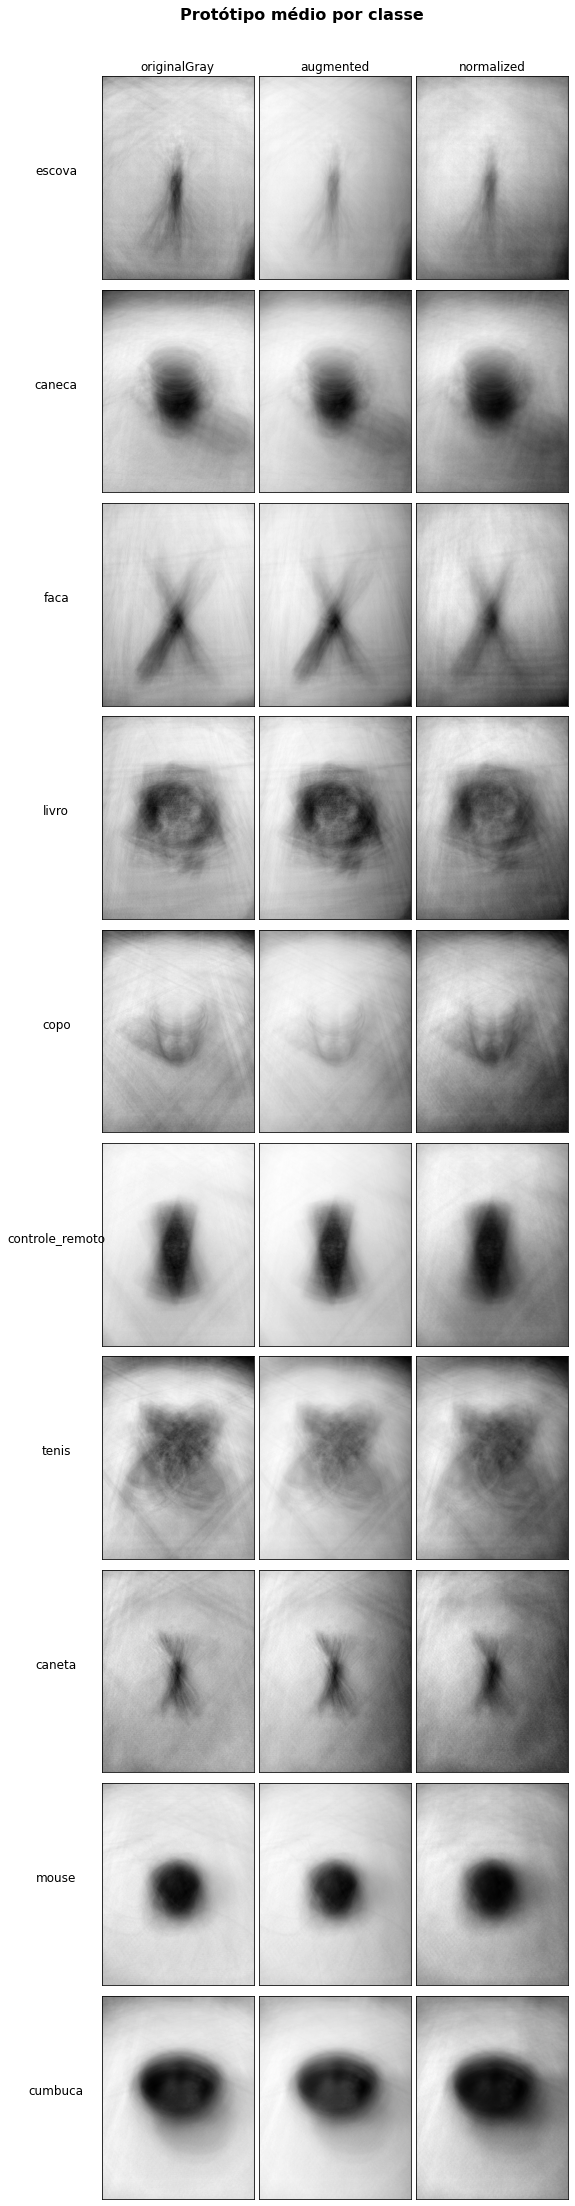

In [48]:
plot_prototypes()

In [82]:
def plot_histograms():
    cl_labels = orig_gray_df.classe.unique()
    hists = [og_hist, aug_hist, norm_hist]
    variances = [og_var, aug_var, norm_var]
    data_labels = ['originalGray', 'augmented', 'normalized']
    rows = ['{}'.format(classe) for classe in cl_labels]
    fig, axes = plt.subplots(nrows=cl_labels.size, ncols=3, figsize=(12, 30))

    for ax, row in zip(axes[:,0], rows):
        ax.set_ylabel(row, rotation=0, size='large')
        ax.yaxis.set_label_coords(-0.3, 0.5)
    
    for ax, label in zip(axes[0,:], data_labels):
        ax.set_title(label, size='large')

    for r in range(cl_labels.size):
        for c in range(3):
            axes[r,c].step(x=np.arange(256), y=hists[c][r])
            axes[r,c].tick_params(axis='both', which='both', length=0)
            plt.setp(axes[r,c].get_xticklabels(), visible=False)
            plt.setp(axes[r,c].get_yticklabels(), visible=False)
     
    fig.suptitle('Histograma médio por classe', weight='bold', y=1.02, fontsize=16)
    fig.tight_layout()
    plt.show()

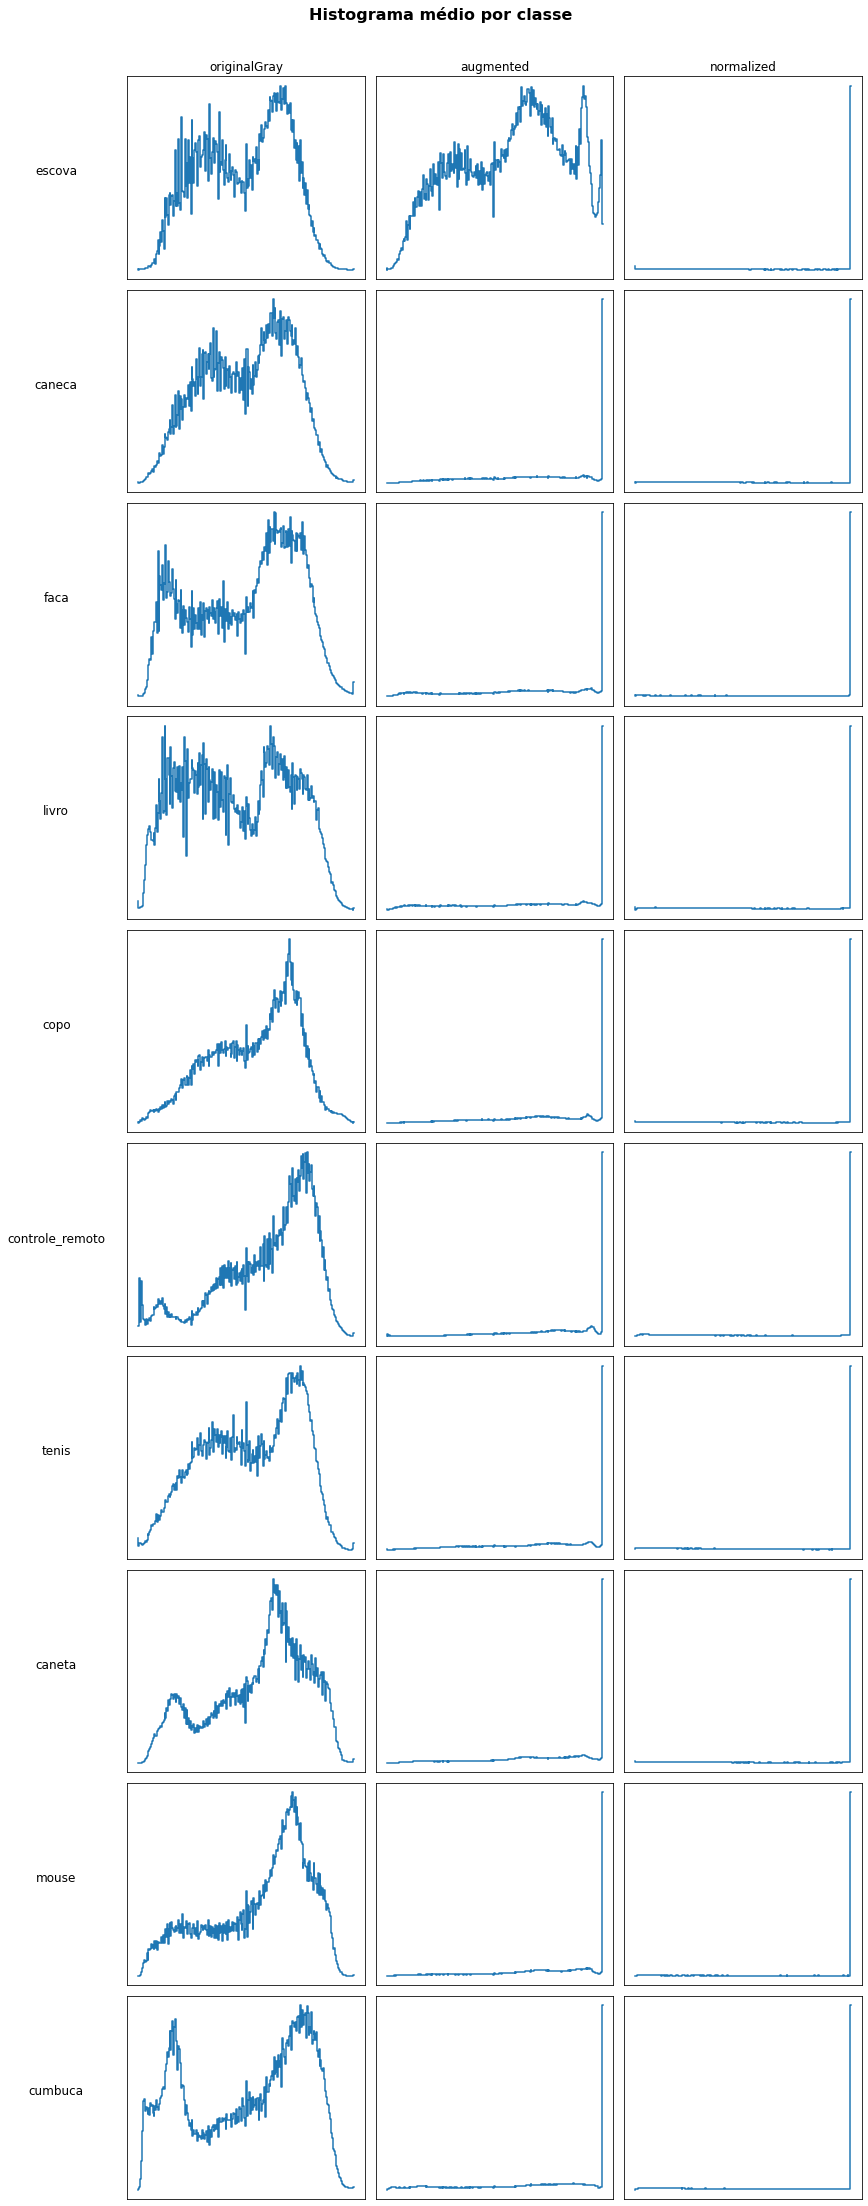

In [83]:
plot_histograms()